In [240]:
import numpy as np
import pandas as pd
#import modin.pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import sparse
from tqdm import tqdm

%matplotlib inline

In [2]:
# !pip install modin

# Сырые данные

## Считываем данные из .csv

Некоторые данные (такие как рубрики и признаки), представлены строками значений. Преобразуем их в списки чисел. 

In [3]:
to_list = lambda rubrics: [int(rubric) for rubric in str(rubrics).split(' ')]
def apply_to_columns(df, columns, func=to_list):
    for column in columns:
        df.loc[~df[column].isnull(), column] = df.loc[~df[column].isnull(), column].apply(func)

В первую очередь нам понадобятся данные по __пользователям__, __организациям__ и сами __отзывы__. 

In [4]:
users = pd.read_csv('data/users.csv') # Информация о городе проживания пользователя:
print('Users: ', users['user_id'].nunique())
users.head(3)

Users:  1252801


,user_id,city
0,523295021912509756,msk
1,11952159487361099606,msk
2,16879036589969590999,msk


# NLP

Описание извлекаемых из отзывов аспектов. Множество аспектов извлекается из отзыва с помощью NLP-алгоритма и может быть неточным.


In [5]:
aspects = pd.read_csv('data/aspects.csv')
aspects.sample(5)

,aspect_id,aspect_name
62,279,Русская Кухня
137,376,Банкет
77,294,Паназиатская Кухня
66,283,Узбекская Кухня
19,20,Спортивные трансляции


Описание особенностей организаций. Как правило, множество особенностей организации заполняется ее владельцем 
и может быть неточным.

In [6]:
features = pd.read_csv('data/features.csv')
features.sample(5)

,feature_id,feature_name
9,10428,hall_capacity
51,3501745827,food_product_delivery
62,3502010938,wheelchair_accessible
45,3501539205,vinotheque
55,3501773763,automatic_door


In [150]:
orgs = pd.read_csv('data/organisations.csv')
print('orgs', len(orgs))
columns = ['rubrics_id', 'features_id'] # create lists
apply_to_columns(orgs, columns)

orgs.head(5)

orgs 66405


,org_id,city,average_bill,rating,rubrics_id,features_id
0,16848414477362211020,spb,1000.0,4.479702,"[30776, 31375]","[1018, 1509, 11177, 11617, 11629, 11704, 11867..."
1,1430604733320164116,spb,1000.0,4.514509,"[30776, 30770]","[246, 1018, 11617, 11629, 11704, 11867, 20422,..."
2,9880309324224147401,spb,1000.0,3.884615,"[30770, 30774]","[1018, 11177, 11617, 11629, 11704, 11867, 2042..."
3,5617879987171966456,spb,1000.0,NaN,"[30774, 30775]","[1018, 1509, 10596, 11177, 11629, 11634, 11704..."
4,5241461680470612149,spb,1000.0,4.532468,[30776],"[1018, 11177, 11617, 11629, 11704, 11867, 2042..."


`organisations.csv` - Информация об организациях:

* `org_id:` идентификатор организации
* `city_id:` город организации
* `average_bill:` средний чек в рублях (округленный с точностью до 500 рублей)
* `avg_rating:` средний рейтинг (в том числе с учетом не перечисленных в файле reviews.csv отзывов и оценок)
* `rubric_id:` рубрика опрганизации
* `feature_ids:` набор известных особенностей данной организации.

In [151]:
def count_feature(x):
    try: return len(x)
    except: return 0

orgs['feature_count'] = orgs['features_id'].apply(count_feature)
orgs.rename(columns = {'feature_count':'org_feature_count',
                      'features_id':'org_features_id'}, inplace=True)

orgs.sample(3)

,org_id,city,average_bill,rating,rubrics_id,org_features_id,org_feature_count
12129,8397957854640439951,spb,NaN,5.000000,[30519],"[11177, 11629, 11704, 11867, 273469383, 350161...",6
7849,10938088155189314887,msk,500.0,4.190000,"[30777, 30774]","[1018, 11617, 20422]",3
51534,16514892677454463859,msk,NaN,4.642857,[30774],NaN,0


In [152]:
# orgs.org_feature_count.hist(bins=30)

In [153]:
# # orgs.feature_count.hist()
# orgs.average_bill.value_counts()

Чтобы не делать __join__ каждый раз, когда нам потребуется узнать, из какого города организация или пользователь, сразу добавим эту информацию в отзывы - `reviews.csv` - обучающее множество собрано за `X = 1217` дней, тестовое множество – за последующие `Y = 107` дней.

В этом файле дана информация об отзывах и оценках, оставленных некоторым множеством жителей Москвы и Санкт-Петерубрга в течение обучающего периода:

* `user_id`: идентификатор пользователя
* `org_id`: идентификатор организации
* `ts`: время отзыва (в днях от начала обучающего периода)
* `rating`: поставленная оценка
* `aspect_ids`: набор упомянутых в тексте отзыва аспектов.

In [154]:
reviews = pd.read_csv('data/reviews.csv', low_memory=False)

print('Reviews: ', len(reviews))
print('Users review: ', reviews.user_id.nunique())
print('Ogs review: ', reviews.org_id.nunique())

# encode users ids as numeric
print('Приклеим информацию по юзерам')
reviews = reviews.merge(users, on='user_id', how='left')
reviews = reviews.rename({'city' : 'user_city'}, axis=1)

print('Приклеим информацию по организациям')
orgs.rename({'rating': 'org_rating'}, axis=1, inplace=True)
reviews = reviews.merge(orgs[['org_id', 'city', 'org_rating', 'org_feature_count','average_bill']], on='org_id', how='left') # encode orgs ids as numeric
reviews = reviews.rename({'city': 'org_city'}, axis=1)

columns = ['aspects'] # create lists
apply_to_columns(reviews, columns)

print('Удалим дубли')
len_before_drop_duplics = len(reviews)
reviews.drop_duplicates(['user_id', 'org_id', 'rating', 'ts','user_city', 'org_city'], inplace=True) # Удаляем дубли
len_after_drop_duplics = len(reviews)
print('Выброшено дублей: ', len_before_drop_duplics - len_after_drop_duplics)

reviews.sample(7)

Reviews:  3640835
Users review:  1252801
Ogs review:  66405
Приклеим информацию по юзерам
Приклеим информацию по организациям
Удалим дубли
Выброшено дублей:  58038


,user_id,org_id,rating,ts,aspects,user_city,org_city,org_rating,org_feature_count,average_bill
1475131,266675283170233630,16696633557167690806,5.0,1164,[7],msk,msk,3.946685,12,1000.0
2876364,10444996810724216495,3211406205074298861,2.0,1170,NaN,msk,msk,4.395833,0,NaN
2349663,17054127033113514606,13225228120465186798,3.0,612,NaN,msk,msk,4.446033,3,NaN
1973337,17634016419731128869,14114500137164303425,5.0,611,NaN,spb,spb,4.140753,9,NaN
244158,14499419197861400193,13025842553497468165,5.0,825,NaN,spb,spb,4.336904,10,NaN
3062886,6188326781478318054,1793775470084163321,4.0,585,NaN,spb,spb,4.360964,9,NaN
465989,12379504198126656967,3636221534643660721,5.0,380,NaN,msk,msk,4.343353,18,1000.0


In [155]:
print("Добавим фичей")    


print('Добавим фичей по туристам')
tourist_only = reviews[reviews['org_city'] != reviews['user_city']].copy()
tourist_only = tourist_only.groupby(by='org_id', as_index = False).agg(org_tourist_mean_rating = ('rating', 'mean'),
                                                                       org_tourist_popularity = ('rating', 'count'))
reviews = reviews.merge(tourist_only[['org_id', 'org_tourist_mean_rating', 'org_tourist_popularity']], on='org_id', how='left')
#Заполним пропуски по местам, где вообще не было раньше туристов
reviews[['org_tourist_mean_rating', 'org_tourist_popularity']] = reviews[['org_tourist_mean_rating', 'org_tourist_popularity']].fillna(0)

print('Добавим фичей по аспектам')
reviews['aspect_count'] = reviews['aspects'].apply(count_feature)

print('Добавим фичей популярности по всем пользователям')
popularity = reviews.groupby(by='org_id', as_index = False).agg(org_popularity = ('user_id', 'count'),
                                                               org_rating_agg = ('rating', 'mean'),
                                                               org_aspect_mean = ('aspect_count', 'mean'))
reviews = reviews.merge(popularity[['org_id', 'org_popularity','org_rating_agg','org_aspect_mean']], on='org_id', how='left') # encode orgs ids as numeric
activity = reviews.groupby(by='user_id', as_index = False).agg(
    user_mean_rating = ('rating', 'mean'),
    user_review_activity = ('rating', 'count'),
    user_aspect_activity = ('aspect_count', 'sum'))
reviews = reviews.merge(activity[['user_id', 'user_mean_rating',
                                  'user_review_activity', 'user_aspect_activity']], on='user_id', how='left') # encode orgs ids as numeric

reviews.sort_values(by=['org_popularity', 'org_feature_count', 'org_rating', 'org_rating_agg', 'aspect_count', 'org_aspect_mean'], inplace=True, ascending=False)
reviews.head(5)

del popularity, activity, tourist_only

Добавим фичей
Добавим фичей по туристам
Добавим фичей по аспектам
Добавим фичей популярности по всем пользователям


**Отлично, теперь с отзывами будет удобно работать.**  Посмотрим на распределение новых отзывов по дням, чтобы понять, как лучше организовать валидацию. 

In [163]:
reviews.sample(10)

,user_id,org_id,rating,ts,aspects,user_city,org_city,org_rating,org_feature_count,average_bill,org_tourist_mean_rating,org_tourist_popularity,aspect_count,org_popularity,org_rating_agg,org_aspect_mean,user_mean_rating,user_review_activity,user_aspect_activity
3218939,9577943789262093074,4008472015869315090,5.0,949,NaN,msk,msk,4.193825,10,500.0,3.750000,4.0,0,324,4.243827,0.314815,4.866667,15,3
14083,7655352102409070275,8877628355418324137,5.0,503,NaN,msk,spb,4.198259,5,500.0,4.333333,75.0,0,406,4.140394,0.133005,5.000000,1,0
2053605,5504031695685006779,9072877885475050764,1.0,665,NaN,msk,msk,3.976471,4,NaN,0.000000,0.0,0,45,3.888889,0.777778,1.000000,1,0
669369,1780399877470594425,14569355903647645386,3.0,795,NaN,msk,msk,4.190923,12,1000.0,4.583333,12.0,0,383,4.156658,0.462141,3.888889,9,0
3235855,1466483782255012489,6848688350703886248,4.0,741,NaN,spb,spb,4.505340,11,1000.0,4.641026,39.0,0,2069,4.517892,0.325278,4.727273,11,3
2567855,2361037119629062480,13573322486152844808,5.0,669,NaN,msk,msk,NaN,3,NaN,4.734286,350.0,0,21502,4.699465,0.028555,5.000000,1,0
1976846,1041129642990352262,8334705288682517030,5.0,629,NaN,spb,spb,4.222892,28,500.0,4.266667,30.0,0,194,4.206186,0.479381,3.500000,2,2
2583307,13712302282481243757,13573322486152844808,5.0,633,NaN,msk,msk,NaN,3,NaN,4.734286,350.0,0,21502,4.699465,0.028555,4.666667,3,0
322934,5119703794116638843,1397149796097415274,5.0,542,NaN,msk,msk,3.945946,8,500.0,0.000000,0.0,0,19,3.736842,0.263158,3.666667,3,2
74250,3624436884452551248,1793775470084163321,4.0,1209,NaN,spb,spb,4.360964,9,NaN,4.448454,194.0,0,4293,4.304824,0.000000,3.666667,3,0


In [164]:
# cor_mat = reviews.corr()
# sns.heatmap(cor_mat, square=True)

In [165]:
print(reviews.columns) # org_rating_agg user_mean_rating org_rating

Index(['user_id', 'org_id', 'rating', 'ts', 'aspects', 'user_city', 'org_city',
       'org_rating', 'org_feature_count', 'average_bill',
       'org_tourist_mean_rating', 'org_tourist_popularity', 'aspect_count',
       'org_popularity', 'org_rating_agg', 'org_aspect_mean',
       'user_mean_rating', 'user_review_activity', 'user_aspect_activity'],
      dtype='object')


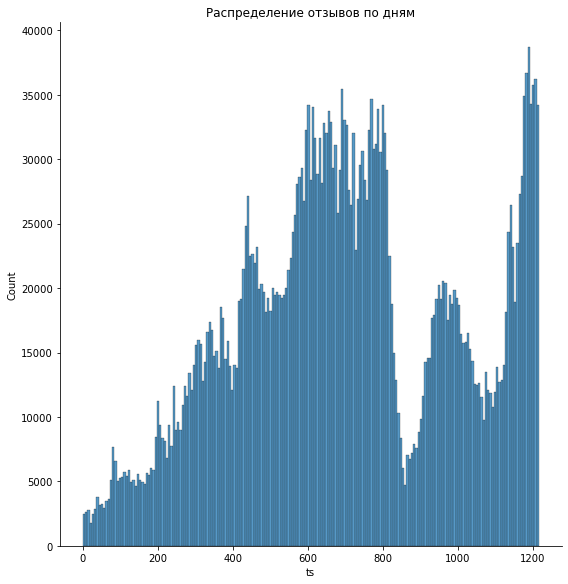

In [159]:
sns.displot(data=reviews, x='ts', height=8)
plt.title('Распределение отзывов по дням')
plt.show()

# Train-test split

In [160]:
from func import clear_df, extract_unique, count_unique, filter_reviews, train_test_split, process_reviews

In [161]:
print('Дней', reviews['ts'].max())

Дней 1216


**Всего в выборку попали отызывы за 1216 дней.**  Отложим в тестовую выборку отзывы за последние **100** дней.

In [162]:
train_reviews, test_reviews = train_test_split(reviews, 1116)
X_test, y_test = process_reviews(test_reviews)

Посмотрим, сколько всего уникальных пользователей попало в эту тестовую выборку:

In [20]:
len(X_test)

12044

# Метрика

Метрика принимает на вход два DataFrame, имеющих такую же структуру, как и **y_test**. `print_score` домножает реальное значение метрики на `100` так же, как и в контесте. Подобная имплементация используется для оценки **submission**.

In [21]:
from func import MNAP, print_score

In [22]:
N = 20
MNAP_N = MNAP(N)

# Подходы без машинного обучения

In [56]:
spb_orgs = orgs[orgs['city'] == 'spb']['org_id']
msk_orgs = orgs[orgs['city'] == 'msk']['org_id']
test_users_with_locations = X_test.merge(users, on='user_id')

## N самых популярных мест

Предыдущий подход, очевидно, не очень удачно предсказывает, какие места посетит пользователей. 

Попробуем улучшить стратегию: будем предлагать пользователям самые популярные места, то есть те, на которые оставлено больше всего отзывов. 

In [23]:
msk_orgs = train_reviews[(train_reviews['rating'] >= 4) & (train_reviews['org_city'] == 'msk')]['org_id']
msk_orgs = msk_orgs.value_counts().index[:N].to_list()

spb_orgs = train_reviews[(train_reviews['rating'] >= 4) & (train_reviews['org_city'] == 'spb')]['org_id']
spb_orgs = spb_orgs.value_counts().index[:N].to_list()

In [24]:
choose = lambda x: spb_orgs if x['city'] == 'msk' else msk_orgs
target = test_users_with_locations.apply(choose, axis=1)

predictions = X_test.copy()
predictions['target'] = target

print_score(MNAP_N(y_test, predictions))

Score: 4.24


Отлично, метрика немного улучшилась. Но стоит попробовать доработать эту тактику. 

## N самых популярных мест среди туристов

In [25]:
tourist_reviews = train_reviews[train_reviews['rating'] >= 4.0]

# набор отзывов только от туристов
tourist_reviews = tourist_reviews[tourist_reviews['user_city'] != tourist_reviews['org_city']]

# выбираем самые популярные места среди туристов из Москвы и Питера
msk_orgs = tourist_reviews[tourist_reviews['org_city'] == 'msk']['org_id']
msk_orgs = msk_orgs.value_counts().index[:N].to_list()

spb_orgs = tourist_reviews[tourist_reviews['org_city'] == 'spb']['org_id']
spb_orgs = spb_orgs.value_counts().index[:N].to_list()

In [26]:
choose = lambda x: spb_orgs if x['city'] == 'msk' else msk_orgs
target = test_users_with_locations.apply(choose, axis=1)

predictions = X_test.copy()
predictions['target'] = target

print_score(MNAP_N(y_test, predictions))

Score: 6.44


Метрика улучшилась ещё!

<AxesSubplot:>

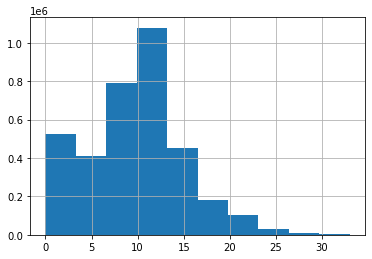

In [27]:
reviews.org_feature_count.hist()

## N самых популярных мест среди туристов с учетом оценки заведения

In [212]:
tourist_reviews = train_reviews[(train_reviews['rating'] >= 4.0) & (train_reviews['org_rating'] >=  4.1)
                               & (train_reviews['user_mean_rating'] >=  4)]
  
     
    
# org_rating_agg user_mean_rating org_rating
# набор отзывов только от туристов
tourist_reviews = tourist_reviews[tourist_reviews['user_city'] != tourist_reviews['org_city']]

# выбираем самые популярные места среди туристов из Москвы и Питера
msk_orgs = tourist_reviews[tourist_reviews['org_city'] == 'msk']['org_id']
msk_orgs = msk_orgs.value_counts().index[:N].to_list()

spb_orgs = tourist_reviews[tourist_reviews['org_city'] == 'spb']['org_id']
spb_orgs = spb_orgs.value_counts().index[:N].to_list()

In [213]:
choose = lambda x: spb_orgs if x['city'] == 'msk' else msk_orgs
target = test_users_with_locations.apply(choose, axis=1)

predictions = X_test.copy()
predictions['target'] = target

print_score(MNAP_N(y_test, predictions))

Score: 6.52


Метрика улучшилась ещё немного.

## N / rubrics_count самых популярных мест из каждой рубрики

In [30]:
from func import extract_top_by_rubrics

In [31]:
orgs.head(2)

,org_id,city,average_bill,org_rating,rubrics_id,features_id,org_feature_count
0,16848414477362211020,spb,1000.0,4.479702,"[30776, 31375]","[1018, 1509, 11177, 11617, 11629, 11704, 11867...",11
1,1430604733320164116,spb,1000.0,4.514509,"[30776, 30770]","[246, 1018, 11617, 11629, 11704, 11867, 20422,...",10


In [49]:
# reviews_ = reviews.merge(orgs, on='org_id')[['org_id', 'rubrics_id']]
# reviews_

,org_id,rubrics_id
0,9104453017196776235,"[31495, 30774]"
1,9104453017196776235,"[31495, 30774]"
2,9104453017196776235,"[31495, 30774]"
3,9104453017196776235,"[31495, 30774]"
4,9104453017196776235,"[31495, 30774]"
...,...,...
3582792,10528864831168312063,[30775]
3582793,10743345342945927825,"[30776, 30775]"
3582794,15416008873049229749,[30771]
3582795,9536174753219613502,[30776]


In [ ]:
# reviews_ = reviews_.explode('rubrics_id')#.groupby('rubrics_id').size()

In [62]:
# reviews_.groupby('rubrics_id').size()

In [45]:
msk_orgs = extract_top_by_rubrics(orgs, tourist_reviews[tourist_reviews['org_city'] == 'msk'], N, print_rubrics=True)
spb_orgs = extract_top_by_rubrics(orgs, tourist_reviews[tourist_reviews['org_city'] == 'spb'], N, print_rubrics=True)

Empty DataFrame
Columns: [rubric_id, 0]
Index: []
Empty DataFrame
Columns: [rubric_id, 0]
Index: []


In [35]:
choose = lambda x: spb_orgs if x['city'] == 'msk' else msk_orgs
target = test_users_with_locations.apply(choose, axis=1)

predictions = X_test.copy()
predictions['target'] = target

print_score(MNAP_N(y_test, predictions))

Score: 5.74


# Время ML! Коллаборативная фильтрация

## Memory-based

Для этой группы методов требуется явное построение матрицы __пользователь-организация__ (__interaction matrix__), где на пересечении `i`-ой строки и `j`-ого столбца будет рейтинг, который `i`-ый пользователь выставил `j`-ой организации или же пропуск, если рейтинг не был установлен. 

In [36]:
from func import reduce_reviews, create_mappings, map_ids, interaction_matrix

## ALS

In [37]:
import implicit  # !pip install implicit

In [38]:
def make_predictions(interactions, X_test, N, mod='ALS'):
    '''
    make_predictions(interactions, X_test, N)
        Делает рекомендации для пользователей из <X_test> на основе матрицы взаимодействий. 
        
        Parameters
        ----------
        interactions : scipy.sparse.csr_matrix
            Разреженная матрица взаимодействий.
            
        X_test : pd.DataFrame
            Набор тестовых пользователей, для которых нужно сделать рекомендации. 
        
        N : int
            Число рекомендаций для каждого пользователя. 
        
        Returns
        -------
        predictions : pd.DataFrame
            DataFrame с колонками <user_id> и <target>. 
            В <target> содержится список рекомендованных для пользователя org_id.
        
    '''
    
    
    predictions = X_test[['user_id']].copy()
    predictions['target'] = pd.Series(dtype=object)
    predictions = predictions.set_index('user_id')
    
    
    interactions, (train_users_len, inner_orgs_len), mappings = interactions
    (index_to_uid, uid_to_index), (index_to_oid, oid_to_index) = mappings

    base_model = implicit.als.AlternatingLeastSquares(#use_gpu=True, 
        factors=30,  iterations=1000, 
        regularization=0.05,  random_state=42,
        num_threads = 4,
        #calculate_training_loss=True
    )
    base_model.fit(interactions.T)

    
    orgs_to_filter = list(np.arange(inner_orgs_len))

    recommendations = base_model.recommend_all(
        interactions,
        N=N,
        filter_already_liked_items=True,
        filter_items=orgs_to_filter,
        show_progress=True
    )
    
    for user_id in tqdm(X_test['user_id'].values, leave=False):
        predictions.loc[user_id, 'target'] = list(
            map(
                lambda org_index: index_to_oid[org_index], 
                recommendations[uid_to_index[user_id]]
            )
        )
        
    return predictions.reset_index()

In [39]:
#mean_rating = train_reviews['rating'].mean()
train_reviews['rating'].fillna(0, inplace=True)


train_reviews = train_reviews[train_reviews['rating'] >= 3]
 
# train_reviews.dropna(inplace=True)
train_reviews.rating.isnull().sum()

2021-10-09 15:37:55,212 [11968] WARNING  py.warnings:109: [JupyterRequire] C:\Users\sasha\anaconda3\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)



0

In [40]:
# train_reviews.isnull().sum()

In [61]:
msk_interactions = interaction_matrix(train_reviews,
                                      test_users_with_locations[test_users_with_locations['city'] == 'msk'],
                                      city = 'msk')

spb_interactions = interaction_matrix(train_reviews,
                                      test_users_with_locations[test_users_with_locations['city'] == 'spb'],
                                      city = 'spb')       
        
test_msk_users = test_users_with_locations[test_users_with_locations['city'] == 'msk']
test_spb_users = test_users_with_locations[test_users_with_locations['city'] == 'spb']

# # Делаем предсказания
# msk_predictions = make_predictions(msk_interactions, test_msk_users, N)
# spb_predictions = make_predictions(spb_interactions, test_spb_users, N)

# predictions = pd.concat([msk_predictions, spb_predictions])

# print_score(MNAP_N(y_test, predictions))

NameError: name 'interaction_matrix' is not defined

# Submission

Выберем лучший метод на валидации, переобучим его на всей выборке и сделаем предсказание на тестовой выборке. 

**Формат вывода:**
Для каждого пользователя из файла `test_users.csv` необходимо приложить список из не более чем 20 организаций, относящихся к городу, отличному от города проживания пользователя.

## Without ML

In [ ]:
# набор отзывов только от туристов


tourist_reviews = reviews[(reviews['rating'] >= 4.0)
                          & (reviews['org_rating'] >= 4.0)
                          & (reviews['user_mean_rating'] >=  4.0)]

tourist_reviews = tourist_reviews[tourist_reviews['user_city'] != tourist_reviews['org_city']]

# выбираем самые популярные места среди туристов из Москвы и Питера
msk_orgs = tourist_reviews[tourist_reviews['org_city'] == 'msk']['org_id']
msk_orgs = msk_orgs.value_counts().index[:N].to_list()

spb_orgs = tourist_reviews[tourist_reviews['org_city'] == 'spb']['org_id']
spb_orgs = spb_orgs.value_counts().index[:N].to_list()


msk_orgs = str(' '.join(map(str, msk_orgs)))
spb_orgs = str(' '.join(map(str, spb_orgs)))

In [ ]:
test_users = pd.read_csv('data/test_users.csv')
test_users['city'] = test_users.merge(users, on='user_id')['city']
test_users.head(3)

In [ ]:
choose = lambda x: spb_orgs if x['city'] == 'msk' else msk_orgs
target = test_users.apply(choose, axis=1)
 
predictions = test_users[['user_id']]
predictions['target'] = target

print(predictions.head(3))

predictions.to_csv('answers_best_valid.csv', index=None)

## With ML

In [ ]:
mean_rating = reviews['rating'].mean()
reviews['rating'].fillna(mean_rating, inplace=True)
reviews = reviews[reviews['rating'] > 3]
reviews.head()

In [ ]:
test_users = pd.read_csv('data/test_users.csv')
test_users = test_users.merge(users, on='user_id')

msk_interactions = interaction_matrix(
    reviews,                                  
    test_users[test_users['city'] == 'msk'][['user_id', 'city']],
    city = 'msk'
)

spb_interactions = interaction_matrix(
    reviews,
    test_users[test_users['city'] == 'spb'][['user_id', 'city']],
    city = 'spb'
)

# msk_predictions = make_predictions(msk_interactions, test_msk_users, N)
# spb_predictions = make_predictions(spb_interactions, test_spb_users, N)

# predictions = pd.concat([msk_predictions, spb_predictions])

In [ ]:
predictions['target'] = predictions['target'].apply(lambda orgs: ' '.join(map(str, orgs)))
predictions.head(2)

In [ ]:
predictions.to_csv('answers_ml.csv', index=None)

# Surprise - SVD/KNN и другие (Андрей/Саша)

In [33]:
from surprise import Reader, Dataset

from surprise import SVD,SVDpp
from surprise import NMF,BaselineOnly, NormalPredictor, KNNWithZScore, SlopeOne, CoClustering
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV

from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

from collections import defaultdict

In [34]:
print('Not Filtered reviews', len(reviews))
surprise_reviews = reviews[(reviews.rating > 2) & (reviews.org_rating > 3.5)]
print('Filtered reviews    ', len(surprise_reviews))

Not Filtered reviews 3582797
Filtered reviews     3078840


In [41]:
# First train an SVD algorithm on the movielens dataset.

surprise_reviews.rename(columns = {'user_id': 'userID',
                          'org_id':'itemID'}, inplace=True)

reader = Reader(rating_scale=(4.0, 5.0))


# The columns must correspond to user id, item id and ratings (in that order).
tourist_reviews.rename(columns = {'user_id': 'userID',
                          'org_id':'itemID'}, inplace=True)

data = Dataset.load_from_df(tourist_reviews[['userID', 'itemID', 'rating']], reader)
# data = Dataset.load_from_df(surprise_reviews[['userID', 'itemID', 'rating']], reader)

trainset = data.build_full_trainset()

algo = SVD(n_epochs=25, verbose=True, random_state=42)

2021-10-08 16:53:29,008 [15256] WARNING  py.warnings:109: [JupyterRequire] C:\Users\sasha\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(



In [54]:
print('Обучение')
algo.fit(trainset)

In [43]:
surprise_reviews.head()

,userID,itemID,rating,ts,aspects,user_city,org_city,org_rating,aspect_count,org_popularity,org_rating_agg,org_aspect_mean,user_mean_rating,user_review_activity,user_aspect_activity
1161175,194140494906478980,9104453017196776235,5.0,752,"[2, 6]",msk,msk,4.638082,2,55931,4.622125,0.004988,4.400000,5,9
1273560,699456224774688518,9104453017196776235,5.0,585,"[2, 6]",msk,msk,4.638082,2,55931,4.622125,0.004988,5.000000,1,2
1759025,3765868620138337538,9104453017196776235,5.0,319,"[2, 23]",msk,msk,4.638082,2,55931,4.622125,0.004988,4.357143,14,4
2911343,377770453372744966,9104453017196776235,3.0,716,"[2, 6]",msk,msk,4.638082,2,55931,4.622125,0.004988,4.400000,5,7
4663,2790039151844604473,9104453017196776235,5.0,1158,[2],msk,msk,4.638082,1,55931,4.622125,0.004988,5.000000,1,1


In [214]:
test_users = pd.read_csv('data/test_users.csv')
users = pd.read_csv('data/users.csv')
test_users = test_users.merge(users, on='user_id')
test_users.sample(3)

,user_id,city
5102,5026676867235415026,msk
13349,7149203965599958700,msk
1365,12526888473773129644,msk


In [59]:
final_preds_dict = {}
thresh = 4

f = lambda orgs: ' '.join(map(str, orgs))


def rep_dict(preds, MIN, item, rating): 
    for k in preds.keys():
        if preds[k] == MIN:
            preds.pop(k)
            preds[item] = rating
            return preds    

def gen_recomend(no_city='msk', limit = 50, thresh=4, ton_n=20, baseline=False):
    
    
    sur_reviews = surprise_reviews[(surprise_reviews.rating >= 3) & (surprise_reviews.org_rating > 4)]
    
    items  = sur_reviews[~(sur_reviews['org_city']==no_city)]['itemID'].unique()# выбираем те орги, где не был юзер

    users_list = test_users[test_users['city']==no_city]['user_id'].values
    
    print('users', len(users_list))
    print('items', len(items))
    
    for user in tqdm(users_list):
        preds_item = {}
#         print('-- user: -->', user)

        filter_ = reviews[reviews['user_id']==user]['org_id'].values # Проверяем,что Item не в списке просмотренных
        filtered_items = [i for i in items if i not in filter_][:limit]
        for item in filtered_items: # TODO убрать костыль
            
            if not baseline:
                print('not baseline')
                rating = algo.predict(uid=user, iid=item).est
            else:
                rating = 5

            if len(preds_item.keys()) < ton_n: # warm start
                preds_item[item] = rating
                
            elif rating > thresh and not baseline:
                MIN = min(preds_item.values()) # Можно вычислять не каждый раз
                if rating > MIN:
                    preds_item = rep_dict(preds_item, MIN, item, rating)
                    
            else:
                break

        assert len(preds_item.keys()) == ton_n
        final_preds_dict[user] = f(preds_item.keys())
    
    print('-----Готово------')
    return final_preds_dict
        #print()
        

In [61]:
msk_preds_dict = gen_recomend(no_city='msk', limit = 40, baseline=True, ton_n=20)
spb_preds_dict = gen_recomend(no_city='spb', limit = 40, baseline=True, ton_n=20)

users 14638
items 11757


  0%|▏                                                                              | 36/14638 [00:07<53:04,  4.59it/s]

KeyboardInterrupt



In [286]:
spb_preds_dict.update(msk_preds_dict)

D = {}

for k, v in spb_preds_dict.items():
    D[k] = v
assert len(D) == len(spb_preds_dict) == 14638 + 2329

users = test_users['user_id'].values
test_users['target'] = None
for i, u in enumerate(users):
    test_users.at[i, 'target'] = D[u]
    
test_users.drop('city', axis=1).to_csv('fil_baseline.csv', index=False)
test_users

NameError: name 'spb_preds_dict' is not defined

# Использование NLP данных 
item-based approches

In [47]:
orgs = pd.read_csv('data/organisations.csv')
org_cols = ['org_id', 'org_city', 'org_rating',
            'org_feature_count', 'org_tourist_mean_rating','org_rating_agg',
            'org_tourist_popularity','org_popularity','org_aspect_mean']

org_features = reviews[org_cols].copy()
org_features.drop_duplicates(inplace=True)

In [48]:
org_features = org_features.merge(orgs[['org_id', 'average_bill', 'rubrics_id', 'features_id']], on='org_id', how='right')
org_features[['rubrics_id','features_id']] = org_features[['rubrics_id','features_id']].fillna('')
org_features.sample(3)

,org_id,org_city,org_rating,org_feature_count,org_tourist_mean_rating,org_rating_agg,org_tourist_popularity,org_popularity,org_aspect_mean,average_bill,rubrics_id,features_id
59626,15343828394400065091,msk,4.219512,2,5.0,4.350000,2.0,60,0.200000,NaN,30774,1018 3501779478
5867,13760711751547548892,msk,3.815789,10,0.0,4.444444,0.0,18,0.722222,1000.0,30776,1018 11617 11629 11704 11867 20422 273469383 2...
56746,621739252194426927,msk,NaN,1,0.0,5.000000,0.0,1,1.000000,NaN,30519 30774 31495,1018


In [50]:
assert len(org_features[(org_features['rubrics_id'].isnull()) & (org_features['features_id'].isnull())]) == 0

In [51]:
print('До', len(org_features)) 
org_features = org_features[(org_features['org_rating'] >= 4) & (org_features['org_tourist_popularity'] > 0)]
print('После', len(org_features)) 

До 66405
После 13363


In [75]:
org_features['text'] =  org_features['rubrics_id'] + org_features['features_id']
org_features.sample(1)

,org_id,org_city,org_rating,org_feature_count,org_tourist_mean_rating,org_rating_agg,org_tourist_popularity,org_popularity,org_aspect_mean,average_bill,rubrics_id,features_id,text
45897,13781785978458860749,spb,4.659091,20,4.9,4.666667,10.0,27,0.296296,2500.0,30774 30776,246 1018 1509 11177 11617 11629 11704 11867 20...,30774 30776246 1018 1509 11177 11617 11629 117...
10177,7336126396593054170,msk,4.120773,4,5.0,4.196581,3.0,117,0.487179,NaN,30776,1018 11617 11629 3501779478,307761018 11617 11629 3501779478
49306,16420734374395567188,msk,4.517857,20,5.0,4.598540,4.0,138,1.014493,1500.0,30776,246 1018 1509 11177 11617 11629 11704 11839 11...,30776246 1018 1509 11177 11617 11629 11704 118...


## Model TfidfVectorizer

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0)

matrix = tf.fit_transform(org_features['text'])

In [67]:
# orgs.org_id.nunique()

In [68]:
from sklearn.metrics.pairwise import linear_kernel

cosine_similarities = linear_kernel(matrix, matrix)

In [70]:
movie_title = org_features['org_id']

In [282]:
indices = pd.Series(org_features.index, index=org_features['org_id'])

f = lambda orgs: ' '.join(map(str, orgs))

def item_recommend_by_item(original_title, top_n = 20, string_format = True, filter_this_city = None):

    idx = indices[original_title]
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31] # TODO фигня какае-то
    movie_indices = [i[0] for i in sim_scores]

    if filter_this_city is not None:
        recoms = [i for i in movie_title.iloc[movie_indices] if i not in filter_this_city][:top_n]
        assert len(recoms) == top_n
    if string_format:
        
        return f(recoms)
    
    return recoms

In [283]:
recoms = item_recommend_by_item(16848414477362211020, filter_this_city = [1, 2])
recoms

'10372168324263760432 1532407218667788426 8123997949364979769 2886272411128436952 6848688350703886248 5659873519308527469 1117450955247384735 3147015073065317414 8362072971451504049 16354016823072778549 6577438793190394985 8227892226937816184 6112508257762746641 7677014565103478282 14540854680567268928 3116833563327929169 17202863923158278919 5062953570852735656 3187371427276178827 584134206767502645'

In [252]:
def get_favorite(user, top = 0):
    visited_item = reviews[reviews['user_id'] == user].sort_values(by = ['rating', 'org_rating'], ascending = False)['org_id']
    assert len(visited_item) > 0,  'Вставить загружку из популярных мест'
    return visited_item.iloc[top]

get_favorite(699456224774688518, top=0)

9104453017196776235

In [253]:
# выбираем самые популярные места среди туристов из Москвы и Питера
msk_orgs_all = org_features[org_features['org_city'] == 'msk']['org_id']
msk_orgs = msk_orgs_all.value_counts().index[:N].to_list()

spb_orgs_all = org_features[org_features['org_city'] == 'spb']['org_id']
spb_orgs = spb_orgs_all.value_counts().index[:N].to_list()


msk_orgs = str(' '.join(map(str, msk_orgs)))
spb_orgs = str(' '.join(map(str, spb_orgs)))

test_users = pd.read_csv('data/test_users.csv')
users = pd.read_csv('data/users.csv')
test_users = test_users.merge(users, on='user_id')
test_users.head(3)

,user_id,city
0,3545210947248911048,msk
1,15271987121288045390,msk
2,15016858616184265932,msk


In [279]:
filter_this_city_choise = lambda city: spb_orgs_all if city == 'msk' else msk_orgs_all
choise = lambda city: spb_orgs if city == 'msk' else msk_orgs

for user, city in tqdm(test_users[['user_id','city']].values):
    filter_this_city = filter_this_city_choise(city)
    visited_item = get_favorite(user, top=0)
    
    try:
        recoms = item_recommend_by_item(visited_item, filter_this_city = filter_this_city)
    except:
        recoms = choise(city)

    test_users.at[test_users['user_id']==user, 'target'] = recoms

100%|███████████████████████████████████████████████████████████████████████████| 16967/16967 [02:38<00:00, 106.99it/s]


In [284]:
test_users.sample(10)

,user_id,city,target
0,3545210947248911048,msk,1293335111489340321 4109208953532773386 660941...
1,15271987121288045390,msk,16848414477362211020 15898295476454639770 1536...
2,15016858616184265932,msk,16848414477362211020 15898295476454639770 1536...
3,12457244142928722989,msk,16848414477362211020 15898295476454639770 1536...
4,13339684649926251468,spb,16178015845392112422 5469965391523691418 11351...
...,...,...,...
16962,1191875913294598364,msk,16848414477362211020 15898295476454639770 1536...
16963,3866507700167344338,msk,16848414477362211020 15898295476454639770 1536...
16964,11434952144484188987,msk,16848414477362211020 15898295476454639770 1536...
16965,7010426792722803474,spb,11484547793853272480 7430373696641345570 32173...


In [285]:
test_users.drop('city', axis=1).to_csv('answers_NLP_cos_sim.csv', index=None)

# LightFM (Саша)

In [ ]:
from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import precision_at_k

# Instantiate and train the model


predictions = X_test[['user_id']].copy()
predictions['target'] = pd.Series(dtype=object)
predictions = predictions.set_index('user_id')


msk_interactions = interaction_matrix(train_reviews,
                                      test_users_with_locations[test_users_with_locations['city'] == 'msk'],
                                      city = 'msk')

interactions, (train_users_len, inner_orgs_len), mappings = msk_interactions
(index_to_uid, uid_to_index), (index_to_oid, oid_to_index) = mappings

In [ ]:
model = LightFM(loss='warp')

model.fit(interactions,
#           user_features=user_features,
#           item_features=item_features,
          epochs=20)
print('Обучился')
test_item_ids = np.arange(inner_orgs_len)
test_user_ids = np.arange(train_users_len)

predictions = model.predict(test_user_ids,
                            test_item_ids,
#                             user_features=user_features,
#                             item_features=item_features
                           )


# # Evaluate the trained model
# test_precision = precision_at_k(model, data['test'], k=5).mean()
# test_precision